<font size = 6>**Detect eye blinks using Pupil Labs' blink detection pipeline**

Detecting eye blinks accurately is a crucial step for many eye tracking applications. On the one hand, the (partial) occlusion of the pupil during eye blinks prevents (hinders) external visual information from entering the retina and, thus, being processed further up the visual hierarchy. In a laboratory setting, for instance, this can be important in order to exclude trials during which a human observer has had no access to the information they were presented with. The (partial) occlusion of the pupil during eye blinks additionally impairs gaze estimation, hence limiting the eye tracker's accuracy. On the other hand, blink statistics, such as blink rate or blink duration, can serve as relevant physiological, clinical, and cognitive parameters. The motivation behind accuratenly detecting eye blinks is therefore two-folds: identifying time periods contaminated by blink-related artifacts as well isolating relevant parameters. <br><br>

This Alpha Lab aims to demonstrate how the Pupil Labs blink detection algorithm works and how to use it. In the first part of the tutorial, we will have a look at offline blink detection. To this end, we will provide an example recording (made with a Neon device) that users can explore. In order to be also <b>accessible by users with little coding experience</b> we provide a high-level interface to the blink detection algorithm. In the second part of this Alpha Lab, we will demonstrate how to utilize the blink detection pipeline in order to <b>detect eye blinks in (quasi) real-time</b>. This section will also provide more in-depth insights into the algorithm and its individual components.<br><br>

The full code accompanying this notebook can be found here: github.com/pupil-labs/

If you want to read a more technical summary of the Pupil Labs blink detection algorithm, you can find a short white paper in the documentation: PROVIDE LINK TO DOCUMENTATION HERE

**<font size = 5>Part 1:** Offline blink detection

In the first part of this Alpha Lab, we will perform offline blink detection. This part is meant to be easily accessible, even with little coding experience. If you have no recording at hand, don't worry - we provide you with an example recording that you can explore. However, free to test the pipeline with your own recording.<br><br>
First, let's import the relevant modules:

In [1]:
from blink_detector.blink_detector import blink_detection_pipeline
from blink_detector.helper import process_recording
import numpy as np

Next, we specify the path to the example recording that we want to analyze. If you want to start exploring the example data set, no changes are needed here. In case you have your own recording that you would like to analyze, simply replace the recording path with a path to your own recording. 

In [2]:
recording_path = "blink_detector/data/padel_tennis_neon_03-2ded8f56"

The Pupil Labs blink detection pipeline computes optical flow from sequences of eye video frames (you can find all the details in the Documentation linked to above). To this end, we first need to extract the frames from the eye camera recording and apply some minor preprocessing to the data. Note that we also have to supply a parameter that specifies if the recording is from a Neon device or not. As the example recording is from a **Neon device**, we set the is_neon parameter to *True*. If you want to try out the blink detection pipeline with an **Invisible recording**, simply set this parameter to *False*. 

In [3]:
left_eye_images, right_eye_images, ts = process_recording(
    recording_path, is_neon=True
)

(-0.5, 2303.5, 191.5, -0.5)

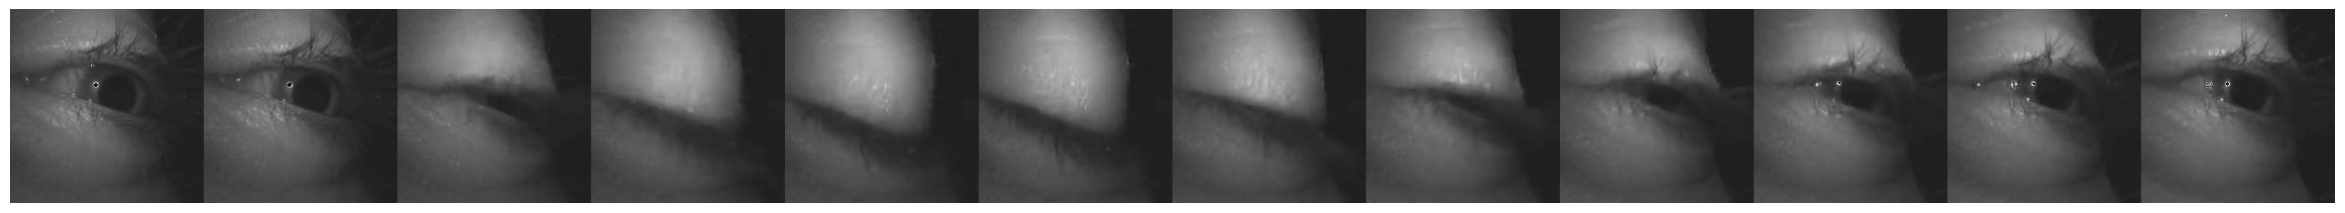

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# fig inches
fig.set_size_inches(30, 10)

images = []
for i in range(1400, 1460, 5):
    # concatenate left images
    images.append(left_eye_images[i, :, :])

images = np.concatenate(images, axis=1)

plt.imshow(images+30, cmap="gray")
plt.axis("off")

 In order to detect eye blinks in the recording, we can now call the blink_detection_pipeline function and pass the extracted left and right eye video frames as well as the corresponding timestamps along. Depending on your computer and the length of your recording (if you run the analysis on your own), this can take a while. The function returns a generator object which can be easily converted into a list of blink events:

In [4]:
blink_events = list(blink_detection_pipeline(left_eye_images, right_eye_images, ts))

**And that's it!**<br><br>
Now that we have extracted the dectected blink events, we can obtain some blink statistics that may be useful further down the line. In the following cell, we print a few of those statistics: the total number of detected blinks, the estimated blink rate (in Hz) as well as the average blink duration (in seconds). We can even divide this further up and look into the average durations of the eyelid closing and the re-opening events:

In [6]:
print(
    f"Number of blinks: {len(blink_events)}"

    f"\nBlink rate [in Hz]: {len(blink_events) / ((ts[-1] - ts[0])/1e9):.2f}"

    f"\nAvg. blink duration [in sec]: {np.mean([blink.blink_duration_s for blink in blink_events]):.3f}"

    f"\nAvg. eyelid closing duration [in sec]: {np.mean([blink.eyelid_closing_duration_s for blink in blink_events]):.3f}"

    f"\nAvg. eyelid opening duration [in sec]: {np.mean([blink.eyelid_opening_duration_s for blink in blink_events]):.3f}"
)

Number of blinks: 21
Blink rate [in Hz]: 0.58
Avg. blink duration [in sec]: 0.300
Avg. eyelid closing duration [in sec]: 0.131
Avg. eyelid opening duration [in sec]: 0.163


As you see, it is fairly straightforward to apply the blink detection pipeline and extract a number of interesting parameters. In case you took a closer look at the blink duration and the eyelid closing and re-opening times and were wondering why the total blink duration does not (always) equal the sum of the closing and re-opening events: this happens as for some frames between eyelid closing and subsequent re-opening, the optical flow is effectively zero and those are, thus, neither part of the closing or re-opening sequence. However, blink duration is computed from starting time of the closing of the eyelid to the the last frame that is classified as being part of the re-opening sequence. Hence, blink duration will always longer than the sum of the invidiual events.<br><br>
To end the first part of this tutorial, we will visualize the detected blinks in order to get an idea of their temporal distribution:

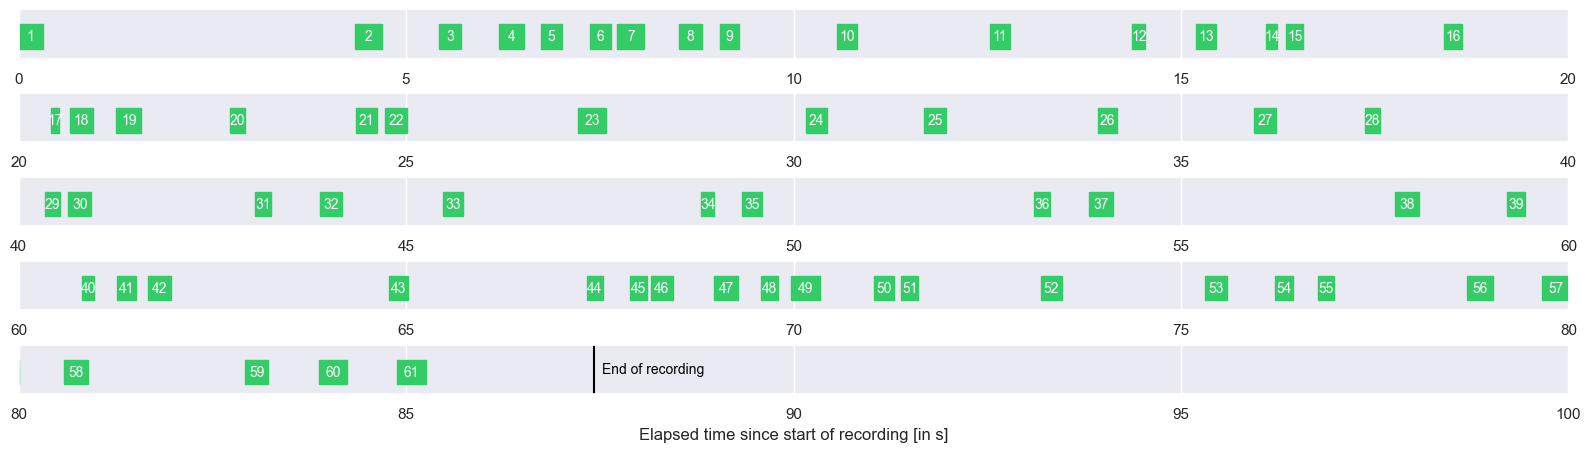

In [5]:
from blink_detector.helper import visualize_blink_events

# Limit the visualization to the first 200 s (if the recording is longer than that)
max_duration = 200

visualize_blink_events(blink_events, ts, max_duration)

We can now see how the detected blinks (shown as green rectangles) are distributed over time and how they vary in duration.

<font size = 5><b>(2) Blink detection in real time using PL's realtime API</b></font>

As you have seen in Part 1, applying the blink detection pipeline to downloaded recordings is fairly straightforward. In the next part of this tutorial, we will show you how you can detect eye blinks in (quasi) real-time utilizing Pupil Lab's Real Time API. This could be useful in order to track blink rate over time (for example, serving as a biomarker of fatigue) or even use certain blink sequences as a means to control an external device. In the following sections, we will show you how to remotely start and stop recordings with your Neon or Invisible device by blinking three times in quick succession.<br><br>

Note that we the temporal resolution of the blink detection is limited by the optical flow parameters (i.e., the number of layers and the layer interval) and postprocessing parameters (e.g. the minimum blink duration). Moreover, depending on your computational resources, the demands of the image processing can further impede performance. Thus, there is an inevitable delay in the blink detection, rendering it only quasi real-time. <br><br>
**Note:** In order to run this second part of the notebook, it is necessary to download and install *Pupil Lab's Realtime Python API*. You can find the code on GitHub (https://github.com/pupil-labs/realtime-python-api) and detailed instructions on how to install and use the realtime API in the documentation (https://pupil-labs-realtime-api.readthedocs.io).

After you have successfully installed the Realtime API, let's first import all the required modules for the realtime blink detection:

In [1]:
import nest_asyncio
import numpy as np
from pupil_labs.realtime_api.simple import discover_one_device
from blink_detector.blink_detector import (
    blink_detection_pipeline,
    successive_blink_detector,
)
from blink_detector.helper import (
    stream_images_and_timestamps,
    update_array,
    compute_blink_rate,
    plot_blink_rate,
)

Next, we need to setup the real time API. We use Python's *asyncio* to implement asynchronous communication. In some environments, for example when working with Jupyter notebooks, asyncio won't work out of the box. We will make use of *nest_asyncio*, which allows *asyncio* to work also within Jupyter notebooks. 

In [2]:
nest_asyncio.apply()

In [3]:
# devices = discover_devices(20)
# device = next(d for d in devices if "tom" in d.phone_name.lower())
device = discover_one_device()

Printing the device name and its IP helps to make sure that the discovered device is indeed <br>
the device you would like to connect with.

In [4]:
print(f"Phone IP address: {device.phone_ip}")
print(f"Phone name: {device.phone_name}")

Phone IP address: 192.168.0.58
Phone name: Neon Companion Tom


Start and end Neon recording with 4 blinks in quick succession. Send event message to Neon with 3 blinks in quick succession.

In [ ]:
def successive_blink_detector(n_successive_blinks=3, time_interval=1.0):
    prev_blink_times = np.zeros(n_successive_blinks)

    def detect_successive_blinks(blink_events):
        nonlocal prev_blink_times

        prev_blink_times = np.roll(prev_blink_times, 1)
        prev_blink_times[0] = blink_events.start_time / 1e9

        if prev_blink_times[0] - prev_blink_times[-1] < time_interval:
            return True
        else:
            return False

    return detect_successive_blinks

In [ ]:
import time
from collections import deque

device_is_recording = False

left_images, right_images, timestamps = stream_images_and_timestamps(
    device, is_neon=True
)

detect_three_successive_blinks = successive_blink_detector(
    n_successive_blinks=3, 
)

# initialize a deque with 3 zeros
blink_queue = deque(maxlen=3)
blink_queue.extend(np.zeros(3))

# time interval within which three blinks should occur
time_interval = 1.0

blink_event_stream = blink_detection_pipeline(left_images, right_images, timestamps)

while True:
    
    blink_event = next(blink_event_stream)

    blink_queue.append(blink_events.start_time / 1e9)
    
    if blink_queue[0] - blink_queue[-1] < time_interval:
        if device_is_recording:
            if time.time() - start_of_recording < 0.5:
                print("Time between start and stop of recording is too short.")
                time.sleep(0.5)
            print("Stop recording")
            device.recording_cancel()
            device_is_recording = False
        else:
            print("Start recording")
            device.recording_start()
            device_is_recording = True
            start_of_recording = time.time()
        toggle_recording = False

**Real-time blink rate since start of recording and over the last 30s**

In this last part of the Alpha Lab, we will show you how to utilize the Realtime API in combination with the blink detection pipeline in order to perform realtime blink-rate estimation.
**Limitation:** As the blink detection pipeline is a generator object, it will block execution of the code until a blink event is yielded. This means that any computation that is carried out within the for-loop will only execute once a blink occurs. This means that blink rate can only be updated once a blink is detected.

In [ ]:
# we need to re-initialize the streams as the previous ones have been exhausted
left_images, right_images, timestamps = stream_images_and_timestamps(
    device, is_neon=True
)

# let's keep track of the last 100 blinks
blink_times = np.zeros(100)
blink_rate_tot = np.zeros(100)
blink_rate_30s = np.zeros(100)

blink_counter = 0
starting_time = time.time()

for blink_events in blink_detection_pipeline(left_images, right_images, timestamps):
    blink_counter += 1

    elapsed_time = blink_events.start_time / 1e9 - starting_time

    blink_times = update_array(blink_times, elapsed_time)

    blink_rate_tot = update_array(
        blink_rate_tot, compute_blink_rate(blink_counter, elapsed_time)
    )

    blink_counter_last_30s = np.sum(blink_times > max(blink_times[0] - 30, 0))

    blink_rate_30s = update_array(
        blink_rate_30s, blink_counter_last_30s / min(30, blink_times[0])
    )

    plot_blink_rate(blink_times, blink_rate_tot, blink_rate_30s)

In [ ]:
import time
from threading import Event, Lock, Thread

from pupil_labs.realtime_api.simple import discover_one_device

frames = []
frames_lock = Lock()

def task1(done_event):

    device = discover_one_device()
    
    while True:
        scene_sample = device.receive_eyes_video_frame()
        frames_lock.acquire()
        frames.append(scene_sample.timestamp_unix_seconds)
        frames_lock.release()
        if done_event.wait(0.00001):
            break

def task2(done_event):

    while True:
        frames_lock.acquire()
        if len(frames) > 1:
            print(f"\r{len(frames)}, {len(frames)/(frames[-1]-frames[0]):.2f} Hz", end="")
        frames_lock.release()
        if done_event.wait(0.00001):
            break

def main():

    try:

        done_event = Event()

        t1 = Thread(target=task1, args=(done_event,))
        t2 = Thread(target=task2, args=(done_event,))

        t1.start()
        t2.start()

        time.sleep(10)
    
    except KeyboardInterrupt:
    
        print("KeyboardInterrupt")
    
    finally:
    
        done_event.set()

        t1.join()
        t2.join()


main()

**(2.4) Run blink detection pipeline**

Detect and print blink events in (quasi) real-time

In [27]:
from collections import deque
import numpy as np

# create a queue of length 3
q = deque(maxlen=3)

# add three zeros to the queue

# add a one to the queue



In [46]:
from collections import deque
q = deque(maxlen=3)


In [48]:
q.append(1)

In [50]:
q[1]

IndexError: deque index out of range